# Initial Setup

In [1]:
import autograd
import autograd.numpy as np
import matplotlib.pyplot as plt
import tqdm.notebook as tqdm
import seaborn as sns

plt.style.use('seaborn-white')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
# ax.tick_params(axis='x', labelsize=16)
# ax.tick_params(axis='y', labelsize=16)

plt.rc('axes', labelsize=20)
plt.rc('font', family='serif')
plt.rc('font', family='serif')
plt.rcParams['image.cmap'] = 'Spectral'

In [2]:
from datetime import datetime
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import odeint
from scipy.spatial.distance import cdist, pdist
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error#,mean_absolute_percentage_error

In [3]:
import dm as diffusion_maps
import parsimonious
from subsample import subsample

In [4]:
start_time = datetime.now()

## Define the Governing ODE

In [5]:
def midlevel_MEK_ERK_model(x, t, k1, k2, k3, k4, k5, k6):
    """
    Evaluate time-derivatives of the six concentrations in Yeung et al.'s kinetic model.
    """
    dS0  = -k1*x[0]*x[5] + k2*x[1]
    dES0 =  k1*x[0]*x[5] - k2*x[1] - k3*x[1]
    dES1 =  k3*x[1] - k4*x[2] + k5*x[5]*x[3] - k6*x[2]
    dS1  =  k4*x[2] - k5*x[5]*x[3]
    dS2  =  k6*x[2]
    dE   = -k1*x[5]*x[0] + k2*x[1] + k4*x[2] - k5*x[5]*x[3] + k6*x[2]
    
    return [dS0, dES0, dES1, dS1, dS2, dE]

## Generate an Initial Sample

In [6]:
use_S2_only = True
generator = np.random.RandomState(12345)

num_samples = 10000
num_steps = 10
E0 = 0.66 # initial concentration of enzyme
C0 = np.array([5.0, 0.0, 0.0, 0.0, 0.0, E0]) # initial concentrations of S0, ES0, ES1, S1, S2, E
time_points = np.linspace(0, 20, num_steps + 1)
delta_k = 0.1 # relative half-width of rate constant perturbations
rate_constants = np.zeros((num_samples, C0.size))
observations = np.zeros((num_samples, (1 if use_S2_only else 6)*num_steps)) # data to be used for DMaps

# # Integrate the ODE for various (randomly perturbed) parameter values:
base_kvals = np.array([0.71, 19, 6700, 9200, 0.97, 5200])
for i in tqdm.trange(num_samples):
    kvals = base_kvals*generator.uniform(low = 1.0 - delta_k, high = 1.0 + delta_k, size = C0.size)
    sol = odeint(midlevel_MEK_ERK_model, C0, time_points, args = tuple(kvals))
    
    # Store rate constant values and observed concentrations:
    rate_constants[i,:] = kvals
    if use_S2_only:
        observations[i,:] = sol[1:,5]
    else:
        observations[i,:] = sol[1:,:].reshape(1,-1)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [7]:

rate_constants  = np.genfromtxt('rate_constants.csv',delimiter = ',')
observations = np.genfromtxt('observations.csv',delimiter = ',')

# Compute DMaps for Parameter Reduction

In [8]:
pw_dists = pdist(observations, "euclidean")
eps_par_red = 10.0*np.median(pw_dists**2) # scale parameter
dmap_par_red = diffusion_maps.SparseDiffusionMaps(points = observations,
                                                  epsilon = eps_par_red,
                                                  num_eigenpairs = 11,
                                                  cut_off = np.inf,  
                                                  renormalization = 0.0,
                                                  normalize_kernel = True)
phi = dmap_par_red.eigenvectors.T # dominant eigenvectors, including the trivial one

## Determine the Independent Components

Subsampling points.
Considering min_distance 0.020000.
Subsampling complete, taking 146 out of 10000 points.
Calculating 9 residuals


Calculating 9 residuals:   0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

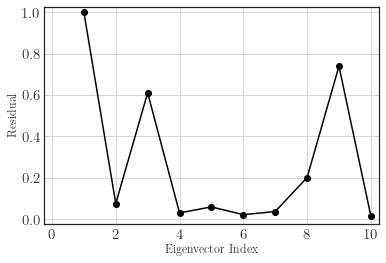

In [9]:
(subsampled_phi, idx_phi) = subsample(phi, min_distance = 0.02)
residuals = parsimonious.DiffusionMap.compute_residuals(subsampled_phi, eps_scale = 3.0)["Residuals"]
indices = np.where(residuals > 0.4)[0] # indices of non-harmonic eigenvectors

fig_residuals = plt.figure(figsize = (6, 4))
ax = fig_residuals.add_subplot(111)
ax.plot(range(1, subsampled_phi.shape[1]), residuals[1:], "ko-")
ax.set_xlim(-0.25, subsampled_phi.shape[1] - 0.75)
ax.set_ylim(-0.025, 1.025)
ax.set_xlabel("Eigenvector Index", fontsize = 12)
ax.set_ylabel("Residual", fontsize = 12)
ax.grid(True)

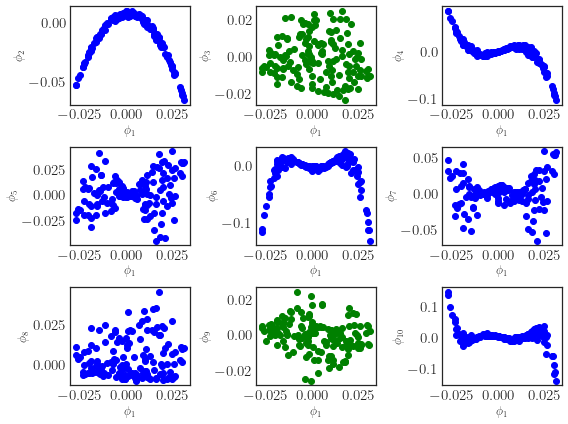

In [10]:
fig_dmaps_evecs = plt.figure(figsize = (8, 6));
for i in range (2,11):
    fmt = "go" if i in indices else "bo"
    ax = fig_dmaps_evecs.add_subplot(3, 3, i-1)
    ax.plot(phi[idx_phi,1], phi[idx_phi,i], fmt)
    ax.set_xlabel(r"$\phi_1$", fontsize = 12)
    ax.set_ylabel(r"$\phi_{%d}$" % i, fontsize = 12)
    ax.grid(False)
plt.tight_layout()

## Compare Data-Driven Observables with Theoretical Parameters

In [11]:
exact_K1 = E0*(rate_constants[:,0]*rate_constants[:,2])/(rate_constants[:,1] + rate_constants[:,2])
exact_K2 = E0*(rate_constants[:,5]*rate_constants[:,4])/(rate_constants[:,5] + rate_constants[:,3])
exact_PI = rate_constants[:,5]/(rate_constants[:,5] + rate_constants[:,3])

effective_params = np.array([exact_K1, exact_K2, exact_PI]).T # effective parameters
evecs = np.squeeze(phi[:,indices]) # eigenvectors

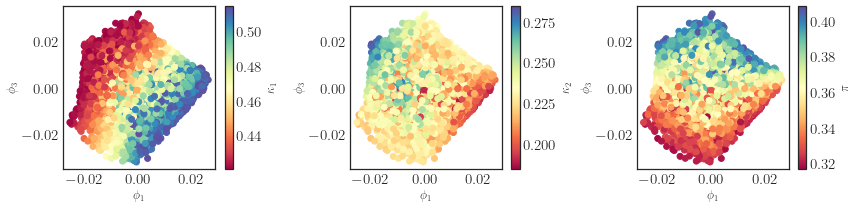

In [12]:
fig_compare_params = plt.figure(figsize = (12, 3))
for (k, lab) in enumerate([r"$\kappa_1$", r"$\kappa_2$", r"$\pi$"]):
    ax = fig_compare_params.add_subplot(131 + k)
    p = ax.scatter(evecs[:,1], evecs[:,2],
                   c = effective_params[:,k],
                   cmap = "Spectral",
                   rasterized = True)
    cs = plt.colorbar(p, ax = ax)
    cs.set_label(lab, fontsize = 12)
    ax.set_xlabel(r"$\phi_1$", fontsize = 12)
    ax.set_ylabel(r"$\phi_{%d}$" % indices[1], fontsize = 12)
plt.tight_layout()

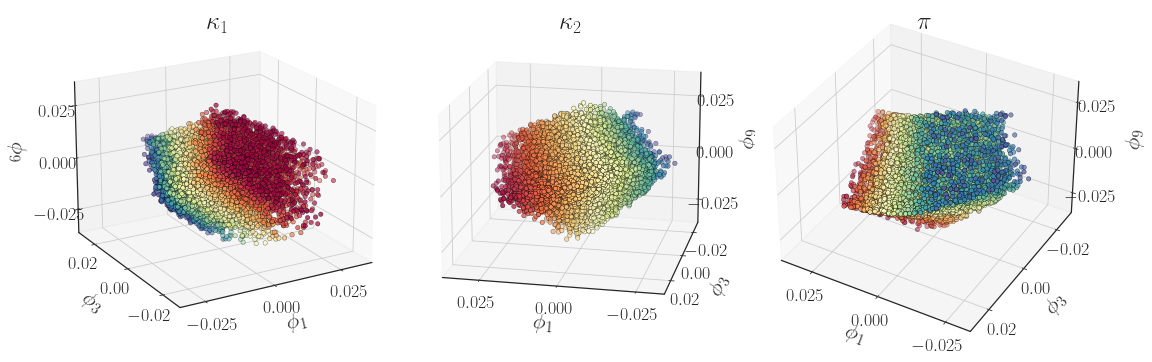

In [13]:
%matplotlib inline

plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
plt.rc('axes', labelsize=18)

fig_compare_params_3d = plt.figure(figsize = (15, 5))
labels = [r"$\kappa_1$", r"$\kappa_2$", r"$\pi$"];
for (k, lab) in enumerate([r"$\kappa_1$", r"$\kappa_2$", r"$\pi$"]):
    ax = fig_compare_params_3d.add_subplot(131 + k, projection = "3d")
    p = ax.scatter(*evecs.T,
                   c = effective_params[:,k],
                   cmap = "Spectral",
                   edgecolors= 'black',
                   linewidths= 0.4,
                   rasterized = True)
    #cs = plt.colorbar(p, ax = ax)
    #cs.set_label(lab, fontsize = 12)
    #ax.set_xticks(np.linspace(-0.04, 0.04, 5))
    ax.set_xlabel(r"$\phi_1$", fontsize = 22)
    #ax.set_yticks(np.linspace(-0.04, 0.04, 5))
    ax.set_ylabel(r"$\phi_{%d}$" % indices[1], fontsize = 22)

    ax.set_zlabel(r"$\phi_{%d}$" % indices[2], fontsize = 22)
    ax.set_title(labels[k],fontsize = 25, y=1.08,pad=-20)
    ax.xaxis.labelpad=7
    ax.yaxis.labelpad=10
    ax.zaxis.labelpad=16
    if k == 0: ax.view_init(20, -120)
    if k == 1: ax.view_init(17, 102)
    if k == 2: ax.view_init(36, 120)
    ax.locator_params(axis="x", nbins=3)
    ax.locator_params(axis="y", nbins=3)
    ax.locator_params(axis="z", nbins=3)


    plt.tight_layout()

# Compute DMaps for Interpolation

In [14]:
np.max(effective_params,axis=0),np.min(effective_params,axis=0)

(array([0.51418644, 0.28443004, 0.40798259]),
 array([0.42040706, 0.18440903, 0.31660412]))

In [15]:
pw_dists = pdist(evecs, "euclidean")
eps_interpolate = np.median(pw_dists**2)

(params_train, params_test, evecs_train, evecs_test) = train_test_split(effective_params, evecs, train_size = 0.99)
dmap_interpolate = diffusion_maps.SparseDiffusionMaps(points = evecs_train,            
                                                      epsilon = eps_interpolate,             
                                                      num_eigenpairs = 200,
                                                      cut_off = np.inf,  
                                                      renormalization = 0.0,
                                                      normalize_kernel = False)
np.min(dmap_interpolate.eigenvalues)

2.368213195406363e-07

## Build Interpolating Functions

In [16]:
interp_K1 = diffusion_maps.GeometricHarmonicsInterpolator(points = evecs_train,
                                                          epsilon = None,
                                                          values = params_train[:,0], 
                                                          diffusion_maps = dmap_interpolate)

interp_K2 = diffusion_maps.GeometricHarmonicsInterpolator(points = evecs_train, 
                                                          epsilon = None,
                                                          values = params_train[:,1], 
                                                          diffusion_maps = dmap_interpolate)

interp_PI = diffusion_maps.GeometricHarmonicsInterpolator(points = evecs_train, 
                                                          epsilon = None,
                                                          values = params_train[:,2], 
                                                          diffusion_maps = dmap_interpolate)

## Compute the Interpolation Error

In [17]:
K1_train = interp_K1(evecs_train); K1_test = interp_K1(evecs_test);
K2_train = interp_K2(evecs_train); K2_test = interp_K2(evecs_test);
PI_train = interp_PI(evecs_train); PI_test = interp_PI(evecs_test);

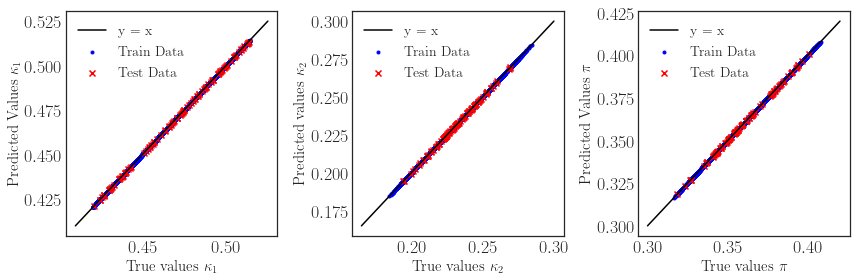

In [18]:
fig_compare_params = plt.figure(figsize = (4*3, 4))
ax = fig_compare_params.add_subplot(131)
p = ax.scatter(params_train[:,0], K1_train,marker = '.',c = 'b',label = 'Train Data')
p = ax.scatter(params_test[:,0], K1_test,marker = 'x', c = 'r',label = 'Test Data')
p = ax.plot(np.linspace(0.41,0.525,10),np.linspace(0.41,0.525,10),'k', label = 'y = x')
ax.set_xlabel("True values " + r"$\kappa_1$",fontsize =15)
ax.set_ylabel("Predicted Values " + r"$\kappa_1$" % indices[1],fontsize =15)
plt.legend(fontsize=14)
plt.tight_layout()

ax = fig_compare_params.add_subplot(132)
p = ax.scatter(params_train[:,1],K2_train,marker = '.',c = 'b',label = 'Train Data')
p = ax.scatter(params_test[:,1], K2_test,marker = 'x', c = 'r',label = 'Test Data')
p = ax.plot(np.linspace(0.165,0.3,10),np.linspace(0.165,0.3,10),'k', label = 'y = x')
ax.set_xlabel("True values " + r"$\kappa_2$",fontsize =15)
ax.set_ylabel("Predicted values " + r"$\kappa_2$" % indices[1],fontsize =15)
plt.legend(fontsize=14)
plt.tight_layout()

ax = fig_compare_params.add_subplot(133)
p = ax.scatter(params_train[:,2], PI_train,marker = '.',c = 'b',label = 'Train Data')
p = ax.scatter(params_test[:,2], PI_test,marker = 'x', c = 'r',label = 'Test Data')
p = ax.plot(np.linspace(0.3,0.42,10),np.linspace(0.3,0.42,10),'k', label = 'y = x')
ax.set_xlabel("True values " + r"$\pi$",fontsize =15)
ax.set_ylabel("Predicted Values " + r"$\pi$" % indices[1],fontsize =15)
plt.legend(fontsize =14)
plt.tight_layout()

# Check for Invertibility

Above, we use geometric harmonics to construct (an approximate interpolation of) the function that takes DMaps coordinates $\boldsymbol{\phi}=(\phi_1,\phi_3,\phi_9)\in\Phi\subset\mathbb{R}^3$ to values of the three theoretical parameters $(\kappa_1,\kappa_2,\pi)\in\Pi\subset\mathbb{R}^3$ proposed by Yeung et al. We would like this map $f:\Phi\to\Pi$ to be invertible. By construction, $f$ is continuously differentiable, so the Inverse Function Theorem holds that the function is locally invertible on a neighborhood of any point $\boldsymbol{\phi}\in\Phi$ where the Jacobian matrix $$Jf(\boldsymbol{\phi})=\begin{pmatrix}\partial\kappa_1/\partial\phi_1 & \partial\kappa_1/\partial\phi_3 & \partial\kappa_1/\partial\phi_9 \\ \partial\kappa_2/\partial\phi_1 & \partial\kappa_2/\partial\phi_3 & \partial\kappa_2/\partial\phi_9 \\ \partial\pi/\partial\phi_1 & \partial\pi/\partial\phi_3 & \partial\pi/\partial\phi_9\end{pmatrix}$$ has non-zero determinant. If the quantity $\det(Jf)$ is bounded away from zero on our data set, this is a good indication that $f:\Phi\to\Pi$ is globally invertible.

Here, we assess three approaches for computing the Jacobian of $f:\Phi\to\Pi$ as well as the implications of the results for invertibility.

## Define an Object to Perform Geometric Harmonics

In [19]:
def rms_error(true_values, approximations, **kwargs):
    """
    Compute the root-mean-square error of a set of
    measurements, compared against true values.
    """
    return np.sqrt(np.mean((true_values - approximations)**2.0, **kwargs))

rms_train_K1 = rms_error(params_train[:,0], interp_K1(evecs_train))
rms_train_K2 = rms_error(params_train[:,1], interp_K2(evecs_train))
rms_train_PI = rms_error(params_train[:,2], interp_PI(evecs_train))
print("Training RMS Error | K1: %9.3e | K2: %9.3e | PI: %9.3e" % (rms_train_K1, rms_train_K2, rms_train_PI))

rms_test_K1 = rms_error(params_test[:,0], interp_K1(evecs_test))
rms_test_K2 = rms_error(params_test[:,1], interp_K2(evecs_test))
rms_test_PI = rms_error(params_test[:,2], interp_PI(evecs_test))
print("    Test RMS Error | K1: %9.3e | K2: %9.3e | PI: %9.3e" % (rms_test_K1, rms_test_K2, rms_test_PI))

Training RMS Error | K1: 1.974e-05 | K2: 9.072e-07 | PI: 2.638e-05
    Test RMS Error | K1: 1.939e-05 | K2: 8.143e-07 | PI: 2.636e-05


In [20]:
class Lifter(object):
    """
    TO DO: Add docstrings and, perhaps, exception raising.
           Incorporate np.atleast_
    """
    def __init__(self, inputs, outputs, diffusion_maps, copy = True):
        """
        The first axis of inputs/outputs must index the points, i.e.,
              inputs.shape == (num_points, dim_inputs)
             outputs.shape == (num_points, dim_outputs)
        """
        self.X = np.array(inputs, copy = copy)
        self.Y = np.array(outputs, copy = copy)
        self.dmaps = diffusion_maps
        self.extenders = list()
        for i in range(self.Y.shape[1]):
            extender = Lifter.create_GH_extender(self.X, self.Y[:,i], self.dmaps)
            self.extenders.append(extender)
    
    def __call__(self, x_new):
        """
        The first axis of x_new must index the points, i.e.,
              x_new.shape == (num_new_points, dim_inputs)
        """
        if x_new.shape[1] != self.X.shape[1]:
            raise ValueError("Dimension mismatch: %s, %s" % (x_new.shape, self.X.shape))
        
        output = np.zeros((x_new.shape[0], self.Y.shape[1]))
        for j in range(self.Y.shape[1]):
            output[:,j] = self.extenders[j](x_new)
        
        return output
    
    def jacobian(self, x_new):
        """
        The first axis of x_new must index the points, i.e.,
              x_new.shape == (num_new_points, dim_inputs)
        
        Returns an array, JAC, of shape
              (num_new_points, dim_outputs, dim_inputs)
        so that JAC[i,:,:] is the Jacobian of the GH function
        at the i-th point of x_new.
        """
        eps = self.dmaps.epsilon
        vals = np.reshape(self.dmaps.eigenvalues, (-1, 1))
        vecs = self.dmaps.eigenvectors
        alpha = np.matmul(vecs, self.Y)/vals
        
        diffs = (self.X[:,None,:] - x_new[None,:,:]).T
        d2 = np.sum((x_new[:,None,:] - self.dmaps.points[None,:,:])**2.0, axis = 2)
        #d2 = cdist(x_new, self.dmaps.points, metric = "sqeuclidean") # slightly faster, but doesn't work with autograd
        K = np.exp(-d2/(2.0*eps))
        
        JAC = np.zeros((x_new.shape[0], self.Y.shape[1], self.X.shape[1]))
        for i in range(JAC.shape[0]):
            modes = np.matmul(diffs[:,i,:]*K[i,:], vecs.T)
            JAC[i,:,:] = np.matmul(modes, alpha).T/eps
        
        return JAC
    
    @staticmethod
    def create_GH_extender(inputs, outputs, diffusion_maps, copy = True):
        """
        Create a function that performs geometric harmonics for the provided data.
        """
        inputs = np.array(inputs, copy = copy)
        outputs = np.array(outputs, copy = copy)
        vals = diffusion_maps.eigenvalues
        vecs = diffusion_maps.eigenvectors
        ck = np.dot(vecs, outputs)
        alpha = ck/vals

        def GH_extender(x_new):
            d2 = np.sum((x_new[:,None,:] - inputs[None,:,:])**2.0, axis = 2) # matrix of pairwise squared distances
            #d2 = cdist(x_new, inputs, metric = "sqeuclidean") # slightly faster, but doesn't work with autograd
            K = np.exp(-d2/(2.0*diffusion_maps.epsilon))
            return np.dot(K, np.dot(vecs.T, alpha))

        return GH_extender

In [21]:
gh_K1 = Lifter.create_GH_extender(evecs_train, params_train[:,0], dmap_interpolate)
gh_K2 = Lifter.create_GH_extender(evecs_train, params_train[:,1], dmap_interpolate)
gh_PI = Lifter.create_GH_extender(evecs_train, params_train[:,2], dmap_interpolate)
gh_lifter = Lifter(evecs_train, params_train, dmap_interpolate)

## Functions to Compute the Jacobian's Determinant

In [22]:
egrad_K1 = autograd.elementwise_grad(gh_K1)
egrad_K2 = autograd.elementwise_grad(gh_K2)
egrad_PI = autograd.elementwise_grad(gh_PI)

def jac_AD(x_new, determinant = False):
    """
    Compute, via automatic differentiation, the Jacobian matrix (or
    its determinant) for the geometric harmonics interpolation from
    Diffusion Maps coordinate to theoretical parameter values.
    """
    x_new = np.atleast_2d(x_new)
    if len(x_new.shape) > 2:
        raise ValueError("Input array must have two axes.")
    elif x_new.shape[1] != 3:
        raise ValueError("Input data must have three columns.")
    
    J = np.zeros((x_new.shape[0], 3, 3))
    J[:,0,:] = egrad_K1(x_new)
    J[:,1,:] = egrad_K2(x_new)
    J[:,2,:] = egrad_PI(x_new)
    
    if determinant:
        return np.linalg.det(J)
    else:
        return J

In [23]:
def jac_FD(x_new, delta = 1e-4, determinant = False):
    """
    Compute, via centered finite differences, (the determinant of)
    the Jacobian matrix for the geometric harmonics interpolation
    from Diffusion Maps coordinate to theoretical parameter values.
    """
    x_new = np.atleast_2d(x_new)
    if len(x_new.shape) > 2:
        raise ValueError("Input array must have two axes.")
    elif x_new.shape[1] != 3:
        raise ValueError("Input data must have three columns.")
    
    J = np.zeros((x_new.shape[0], 3, 3))
    for i in range(3):
        shift = np.zeros((x_new.shape[0], 3))
        shift[:,i] = delta
        J[:,i,:] = (gh_lifter(x_new + shift) - gh_lifter(x_new - shift))/(2.0*delta)
    
    if determinant:
        return np.linalg.det(J)
    else:
        return J

In [24]:
# Too slow to evaluate:
def jac_GH(x_new, determinant = False):
    """
    Compute, via the imported code for GH, (the determinant of)
    the Jacobian matrix for the geometric harmonics interpolation
    from Diffusion Maps coordinate to theoretical parameter values.
    """
    x_new = np.atleast_2d(x_new)
    if len(x_new.shape) > 2:
        raise ValueError("Input array must have two axes.")
    elif x_new.shape[1] != 3:
        raise ValueError("Input data must have three columns.")
    
    J = np.zeros((x_new.shape[0], 3, 3))
    J[:,0,:] = interp_K1.gradient(x_new)
    J[:,1,:] = interp_K2.gradient(x_new)
    J[:,2,:] = interp_PI.gradient(x_new)
    
    if determinant:
        return np.linalg.det(J)
    else:
        return J

In [25]:
def jac_LC(x_new, determinant = False):
    """
    Compute, via the above Lifter class, (the determinant of) the
    Jacobian matrix for the geometric harmonics interpolation from
    Diffusion Maps coordinate to theoretical parameter values.
    """
    x_new = np.atleast_2d(x_new)
    if len(x_new.shape) > 2:
        raise ValueError("Input array must have two axes.")
    elif x_new.shape[1] != 3:
        raise ValueError("Input data must have three columns.")
    
    J = gh_lifter.jacobian(x_new)
    
    if determinant:
        return np.linalg.det(J)
    else:
        return J

In [26]:
computation_times = dict()
determinants = dict()
methods = ["Automatic Differentiation ",
           "Centered Finite Difference",
           "Lifter Class Gradient Code"]
functions = [jac_AD, jac_FD, jac_LC]

print("Time to Compute det(J) for %d Points:" % evecs.shape[0])
for i in range(len(methods)):
    begin = datetime.now()
    determinants[methods[i]] = functions[i](evecs, determinant = True)
    computation_times[methods[i]] = datetime.now() - begin
    print("%29s --> %s" % (methods[i], computation_times[methods[i]]))

Time to Compute det(J) for 10000 Points:
   Automatic Differentiation  --> 0:01:39.317024
   Centered Finite Difference --> 0:01:15.847434
   Lifter Class Gradient Code --> 0:01:36.110862


(-1.0, 20.0)

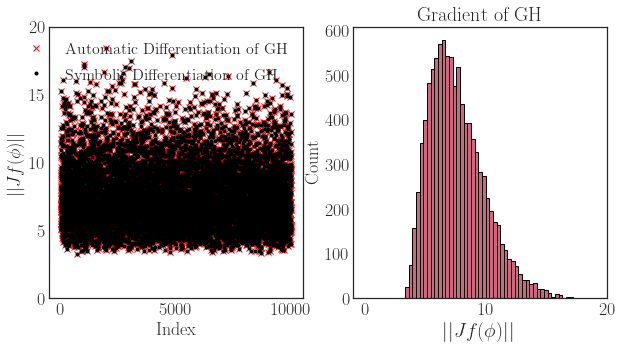

In [27]:
fig_compare_params = plt.figure(figsize = (5*2, 5))
plt.subplot(121)
plt.plot(determinants['Automatic Differentiation '],'rx',label = 'Automatic Differentiation of GH')
plt.plot(determinants['Lifter Class Gradient Code'],'k.',label = 'Symbolic Differentiation of GH')
plt.legend(fontsize = 16)
plt.ylim(0,20); plt.xlabel('Index');plt.ylabel('$||Jf(\phi)||$')


plt.subplot(122)
sns.histplot(determinants['Lifter Class Gradient Code'].reshape(-1,1),
             linewidth=1 ,bins=50, line_kws=dict(alpha=.2), palette='inferno',
             fill=True,color ='red',legend=False)
plt.title('Gradient of GH',fontsize =20)
plt.xlabel('$||Jf(\phi)||$',fontsize =20)
plt.xlim(-1,20)


In [28]:
# Compare Results of the Different Approaches:
for i in range(len(methods)):
    for j in range(i):
        print(methods[i], "|", methods[j], "|", np.allclose(determinants[methods[i]], determinants[methods[j]]))

Centered Finite Difference | Automatic Differentiation  | True
Lifter Class Gradient Code | Automatic Differentiation  | True
Lifter Class Gradient Code | Centered Finite Difference | True


# Predict Effective Parameters from New System Behavior

Our initial DMaps provides a function from the set of observations to diffusion space, that is, $g:X\to\Phi:\boldsymbol{x}=(x_1,\ldots,x_d)\mapsto\boldsymbol{\phi}=(\phi_1,\phi_3,\phi_9)$, where $X$ is the set of initial observation vectors. But the initial data do not represent the entire space, $\overline{X}$, of possible observations, so we need a way to determine the corresponding DMaps coordinates for new experiments with $x_\text{new}\in\overline{X}\setminus X$. The Nyström extension, implemented below, provides such a map. Combining this with the geometric harmonics from above, $f:\Phi\to\Pi$, we can compute the effective parameters that correspond to a newly-observed experiment via the composed function $f\circ g:\overline{X}\to\Pi$.

In [29]:
# Integrate the ODE for various (randomly perturbed) parameter values:
num_new_samples = 100
new_rate_constants = np.zeros((num_new_samples, C0.size))
new_observations = np.zeros((num_new_samples, (1 if use_S2_only else 6)*num_steps))
for i in tqdm.trange(num_new_samples):
    kvals = base_kvals*generator.uniform(low = 1.0 - delta_k, high = 1.0 + delta_k, size = C0.size)
    sol = odeint(midlevel_MEK_ERK_model, C0, time_points, args = tuple(kvals))
    
    # Store rate constant values and observed concentrations:
    new_rate_constants[i,:] = kvals
    if use_S2_only:
        new_observations[i,:] = sol[1:,4]
    else:
        new_observations[i,:] = sol[1:,:]

  0%|          | 0/100 [00:00<?, ?it/s]

## Compute Nyström Extension on New Observations

In [30]:
def nystrom(x_new, dmaps, indices):
    """
    Use the Nystrom extension method to compute DMaps coordinates for a
    new set of observations, relative to a set of already-computed DMaps.
    """
    values = np.reshape(dmaps.eigenvalues[indices], (1, -1))
    vectors = dmaps.eigenvectors[indices].T
    d2 = np.sum((x_new[:,None,:] - dmaps.points[None,:,:])**2.0, axis = 2)
    weights = np.exp(-d2/(2.0*dmaps.epsilon))
    weights /= np.sum(weights, axis = 1, keepdims = True)
    return np.dot(weights, vectors)/values

def dmaps_coordinates(x_new):
    return nystrom(x_new, dmap_par_red, indices)

phi_new = dmaps_coordinates(new_observations)

## Compute Geometric Harmonics on New DMaps Coordinates

In [31]:
estimated_params = gh_lifter(phi_new)

# Compute True Values from Theoretical Expressions:
new_exact_K1 = E0*(new_rate_constants[:,0]*new_rate_constants[:,2])/(new_rate_constants[:,1] + new_rate_constants[:,2])
new_exact_K2 = E0*(new_rate_constants[:,5]*new_rate_constants[:,4])/(new_rate_constants[:,5] + new_rate_constants[:,3])
new_exact_PI = new_rate_constants[:,5]/(new_rate_constants[:,5] + new_rate_constants[:,3])
new_effective_params = np.array([new_exact_K1, new_exact_K2, new_exact_PI]).T

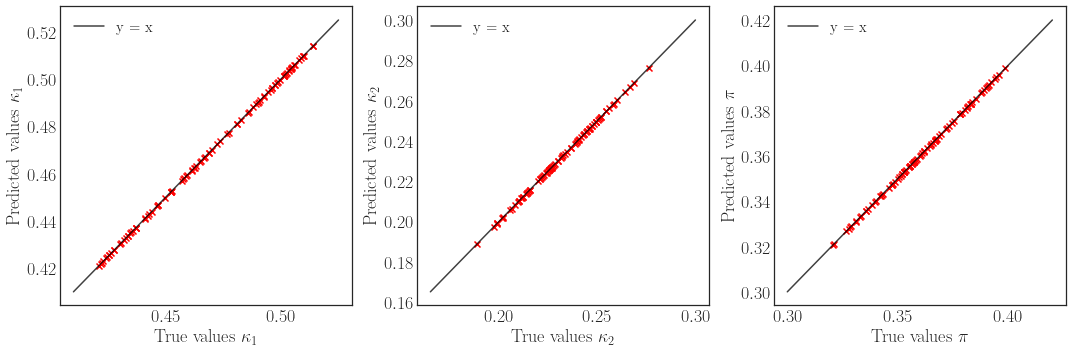

In [32]:
fig_compare_params = plt.figure(figsize = (5*3, 5))
ax = fig_compare_params.add_subplot(131)
p = ax.scatter(new_effective_params[:,0], estimated_params[:,0],marker = 'x',c = 'r')
p = ax.plot(np.linspace(0.41,0.525,10),np.linspace(0.41,0.525,10),'k', label = 'y = x',alpha = 0.75)
ax.set_xlabel("True values " + r"$\kappa_1$")
ax.set_ylabel("Predicted values " + r"$\kappa_1$" % indices[1])
plt.legend(fontsize = 15)
plt.tight_layout()

ax = fig_compare_params.add_subplot(132)
p = ax.scatter(new_effective_params[:,1], estimated_params[:,1],marker = 'x',c = 'r')
p = ax.plot(np.linspace(0.165,0.3,10),np.linspace(0.165,0.3,10),'k', label = 'y = x',alpha = 0.75)
ax.set_xlabel("True values " + r"$\kappa_2$")
ax.set_ylabel("Predicted values " + r"$\kappa_2$" % indices[1])
plt.legend(fontsize = 15)
plt.tight_layout()

ax = fig_compare_params.add_subplot(133)
p = ax.scatter(new_effective_params[:,2], estimated_params[:,2],marker = 'x',c = 'r')
p = ax.plot(np.linspace(0.3,0.42,10),np.linspace(0.3,0.42,10),'k', label = 'y = x',alpha = 0.75)
ax.set_xlabel("True values " + r"$\pi$")
ax.set_ylabel("Predicted values " + r"$\pi$" % indices[1])
plt.legend(fontsize = 15)
plt.tight_layout()


In [33]:
import matplotlib.gridspec as gridspec

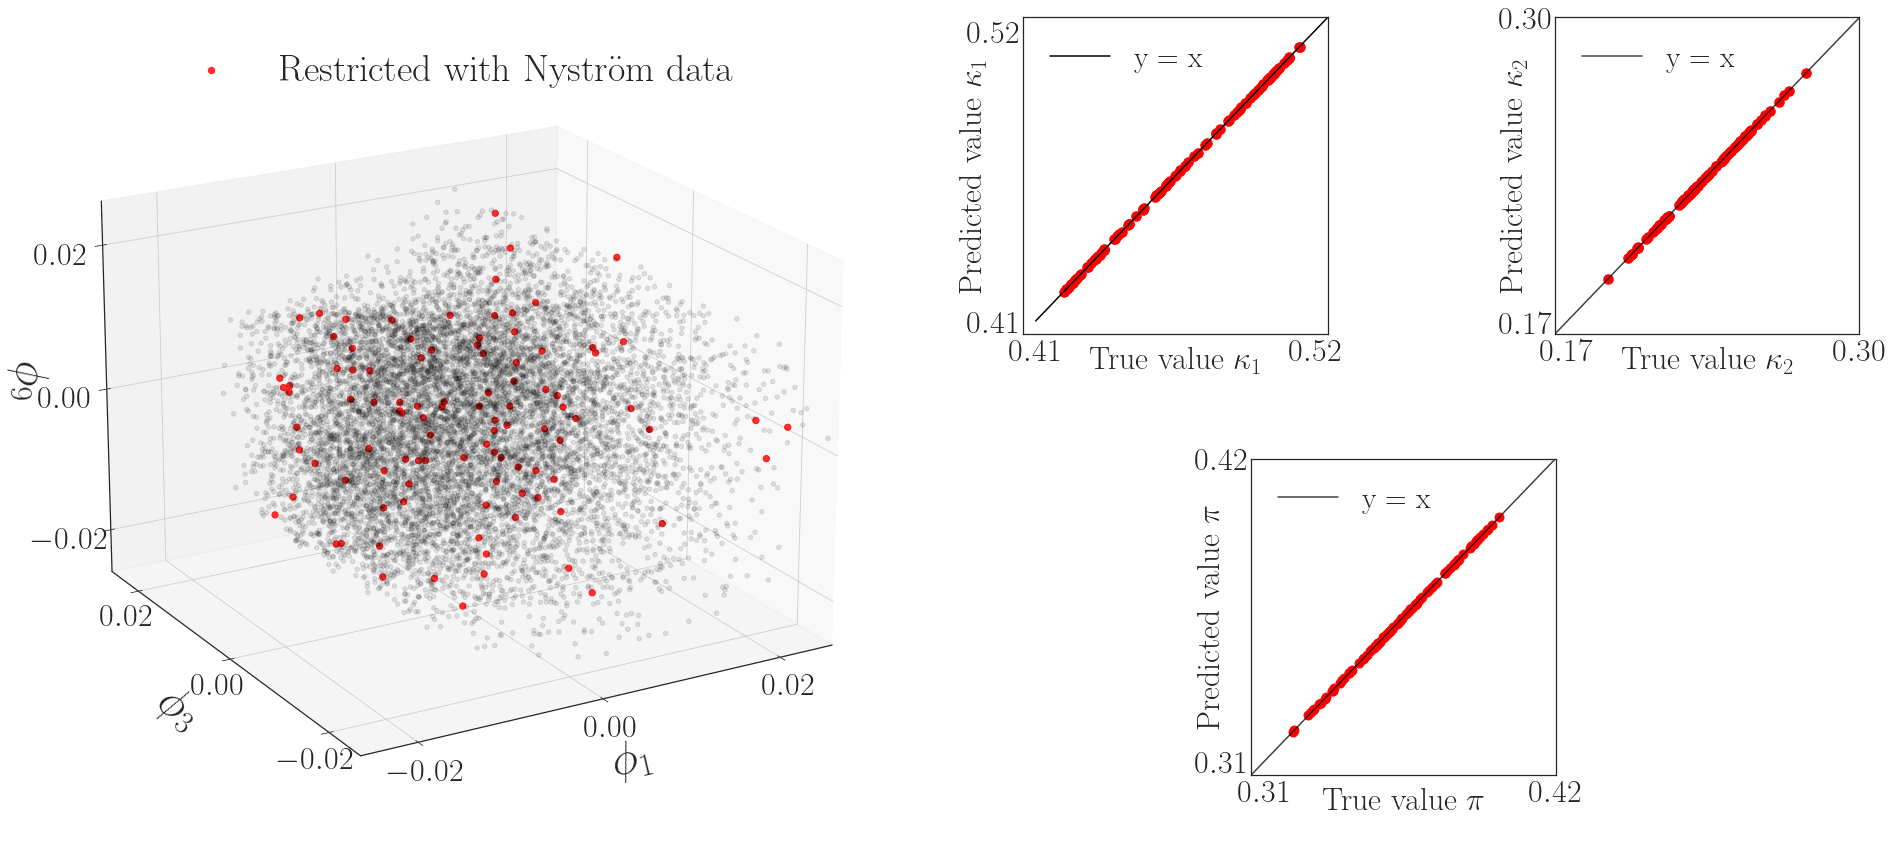

In [34]:
plt.rc('xtick', labelsize=32)
plt.rc('ytick', labelsize=32)
plt.rc('axes', labelsize=32)


fig2 = plt.figure(constrained_layout=False,figsize = (26,12))
spec2 = gridspec.GridSpec(nrows=12,ncols=25,  figure=fig2)
f2_ax1 = fig2.add_subplot(spec2[:, :12],projection = "3d")
p = f2_ax1.scatter(*evecs.T,s = 20,c = 'k',alpha= 0.1)
p = f2_ax1.scatter(*phi_new.T,s = 40,c = 'r',alpha = 0.8,label= 'Restricted with ' + r'Nystr\"{o}m ' + 'data')
f2_ax1.xaxis.labelpad=10
f2_ax1.yaxis.labelpad=15
f2_ax1.zaxis.labelpad=15
f2_ax1.set_xlabel(r"$\phi_1$",fontsize=45)
f2_ax1.set_ylabel(r"$\phi_{%d}$" % indices[1],fontsize=45)
f2_ax1.set_zlabel(r"$\phi_{%d}$" % indices[2],fontsize=45)
f2_ax1.view_init(20, -120)
f2_ax1.set_zlim(-0.025,0.025);
f2_ax1.set_xlim(-0.025,0.025)
f2_ax1.set_ylim(-0.025,0.025);
f2_ax1.xaxis.labelpad=25
f2_ax1.yaxis.labelpad=25
f2_ax1.zaxis.labelpad=28
f2_ax1.tick_params(axis="z",direction="out", pad=18)
f2_ax1.set_xticks(np.array([-0.02,0,0.02]))
f2_ax1.set_yticks(np.array([-0.02,0,0.02]))
f2_ax1.set_zticks(np.array([-0.02,0,0.02]))
plt.legend(fontsize=38,loc='upper center')


f2_ax2 = fig2.add_subplot(spec2[0:5, 13:18])
p = f2_ax2.scatter(new_effective_params[:,0], estimated_params[:,0],
                   marker = 'o',c = 'r',s =90)

p = f2_ax2.plot(np.linspace(0.41,0.53,10),np.linspace(0.41,0.53,10),'k', label = 'y = x')
f2_ax2.set_xlabel("True value " + r"$\kappa_1$")
f2_ax2.set_ylabel("Predicted value " + r"$\kappa_1$" % indices[1])
plt.legend(fontsize =30)
# plt.tight_layout()
plt.locator_params(axis="x", nbins=3)
plt.locator_params(axis="y", nbins=3)
f2_ax2.set_xlim([0.405,0.525]);
f2_ax2.set_ylim([0.405,0.525])
f2_ax2.xaxis.labelpad=-20
f2_ax2.yaxis.labelpad=-20
f2_ax2.set_xticks(np.array([0.41,0.52]))
f2_ax2.set_yticks(np.array([0.41,0.52]))




f2_ax3 = fig2.add_subplot(spec2[0:5, 20:])
p = f2_ax3.scatter(new_effective_params[:,1],estimated_params[:,1],
                   marker = 'o',c = 'r',s =90)
p = f2_ax3.plot(np.linspace(0.165,0.3,10),np.linspace(0.165,0.3,10),'k', label = 'y = x',alpha = 0.75)
f2_ax3.set_xlabel("True value " + r"$\kappa_2$")
f2_ax3.set_ylabel("Predicted value " + r"$\kappa_2$" % indices[1])
# f2_ax3.locator_params(axis="x", nbins=2)
# f2_ax3.locator_params(axis="y", nbins=2)
plt.legend(fontsize =30)
# plt.tight_layout()
f2_ax3.set_xlim([0.165,0.3]);
f2_ax3.set_ylim([0.165,0.3])
# ax.set_xlim([0.165,0.3]);
# ax.set_ylim([0.165,0.3])
f2_ax3.set_xticks(np.array([0.17,0.3]))
f2_ax3.set_yticks(np.array([0.17,0.3]))
f2_ax3.xaxis.labelpad=-20
f2_ax3.yaxis.labelpad=-30




f2_ax4 = fig2.add_subplot(spec2[6:-1, 16:21])
p = f2_ax4.scatter(new_effective_params[:,2], estimated_params[:,2],
                   marker = 'o',c = 'r',s=80)
p = f2_ax4.plot(np.linspace(0.3,0.42,10),np.linspace(0.3,0.42,10),'k', label = 'y = x',alpha = 0.75);
plt.locator_params(axis="x", nbins=3)
plt.locator_params(axis="y", nbins=3)
f2_ax4.set_xlim([0.305,0.42]);
f2_ax4.set_ylim([0.305,0.42])
f2_ax4.set_xlabel("True value " + r"$\pi$")
f2_ax4.set_ylabel("Predicted value " + r"$\pi$" % indices[1])
plt.legend(fontsize =30)

# ax.set_xlim([0.305,0.42]);
# ax.set_ylim([0.305,0.42])
f2_ax4.set_xticks(np.array([0.31,0.42]))
f2_ax4.set_yticks(np.array([0.31,0.42]))
f2_ax4.xaxis.labelpad=-20
f2_ax4.yaxis.labelpad=-30


plt.tight_layout()
